В связи с тем, что время выполнения в colab было очень большим, домашняя работа была сделана в anaconda.

# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [ ]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.13.1


# Загружаем разметку

In [ ]:
import os
import json
from glob import glob

TRAIN_PREFIX = 'data/train'

def load_annotations():
    boxes = dict()
    for path in glob('data/annotations/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):

    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=4)
        return img

    scale_x, scale_y = 1., 1.

    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)

    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)

    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [ ]:
boxes = load_annotations()  # загружаем разметку детекций

In [ ]:
# boxes

In [ ]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

,class,count
0,shark,176
1,yft,734
2,bet,200
3,alb,1719
4,dol,117
5,lag,67


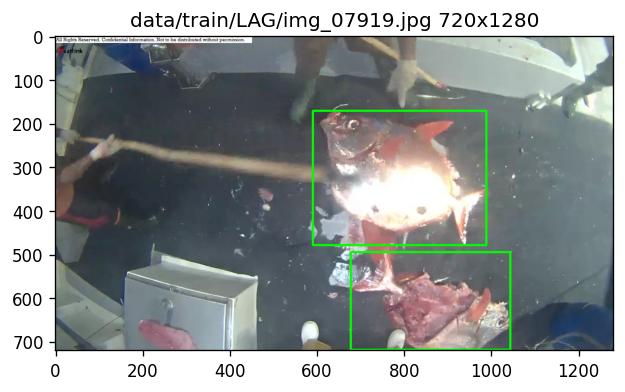

In [ ]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

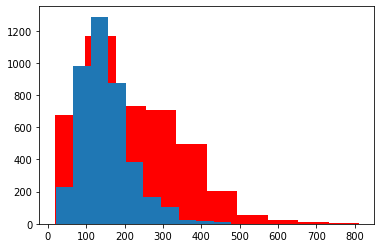

In [ ]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths, color = "r")
plt.hist(heights);

In [ ]:
np.median(widths)

194.73921022742275

In [ ]:
np.median(heights)

141.00000000000034

# Экстрактор признаков

In [ ]:
from tensorflow.keras.applications import vgg16, MobileNetV3Small

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = MobileNetV3Small(weights='imagenet',
                           include_top=False,
                            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 8 слоев
for layer in features.layers[:-8]:
    layer.trainable = False

feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

(None, 24, 38, 576)


# Сетка якорей (anchor grid)

In [ ]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150.

# сетка якорей, размер определяется соотношением
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [ ]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):

    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale

    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale

    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 5), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh]

    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles

    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)

    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

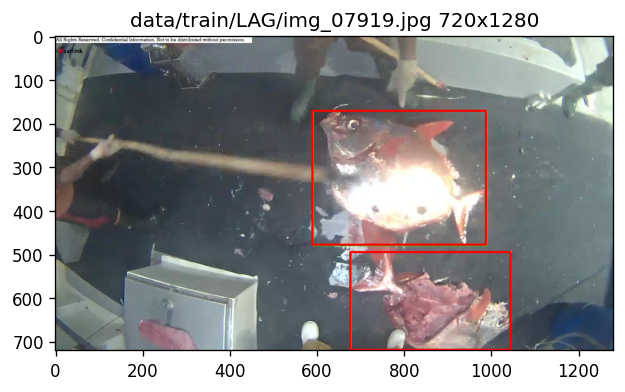

In [ ]:
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [ ]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0],
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]

    # TODO: добавьте функцию потерь для классификации детекции

    # оставим функцию как есть, но используем дополнительную функцию потерь

    y_true = K.reshape(y_true, (batch_size, -1, 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)

    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])

    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)

    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)

    return total_conf_loss + 0.5 * loc_loss

## Загрузка данных

In [ ]:
from random import shuffle

def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

# будущие one_hot_encoding метки
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
ohe_fish = {"ALB": np.array([1, 0, 0, 0, 0, 0]),
            "BET": np.array([0, 1, 0, 0, 0, 0]),
            "DOL": np.array([0, 0, 1, 0, 0, 0]),
            "LAG": np.array([0, 0, 0, 1, 0, 0]),
            "ARK": np.array([0, 0, 0, 0, 1, 0]),
            "YFT": np.array([0, 0, 0, 0, 0, 1])}

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y_1, y_2 = [], [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                class_name = os.path.split(boxes[j]['filename'])[0][-3:]
                # TODO: добавьте one-hot encoding в разметку для классов

                y_1.append(encode_anchors(boxes[j], img_shape))
                y_2.append(ohe_fish[class_name])
                X.append(img)
            yield np.array(X), (np.array(y_1), np.array(y_2))

In [ ]:
gen = data_generator(boxes, batch_size = 5)

In [ ]:
# проверка вывода меток
next(gen)[1][1]

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1]])

## Добавляем выход детектора

In [ ]:
output = tf.keras.layers.BatchNormalization()(feature_tensor)

# TODO: добавьте выходы для классификации детекции
output_1 = tf.keras.layers.Conv2D(5,
                                kernel_size=(1, 1),
                                activation='linear',
                                kernel_regularizer='l2', name = "output_1")(output)

In [ ]:
# добавляем выход для классификатора
output_2 = tf.keras.layers.GlobalMaxPooling2D()(output)
output_2 = tf.keras.layers.Dense(6, activation = 'softmax', name = "output_2")(output_2)

In [ ]:
model = tf.keras.models.Model(inputs=features.inputs, outputs = [output_1, output_2])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 750, 1200, 3)]       0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 750, 1200, 3)         0         ['input_2[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 375, 600, 16)         432       ['rescaling_1[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 375, 600, 16)         64        ['Conv[0][0]']                
 lization)                                                                                  

## Обучение

In [ ]:
adam = tf.keras.optimizers.Adam()
model.compile(optimizer=adam,
              loss = {"output_1": total_loss, "output_2": "categorical_crossentropy"},
              metrics = {"output_1": [confidence_loss], "output_2": ["acc"]})

In [ ]:
batch_size = 5

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values()), 0) // batch_size

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.keras',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto')

history = model.fit(gen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          callbacks=[checkpoint])

Epoch 1/10
602/602 [==============================] - ETA: 0s - loss: 3.3190 - output_1_loss: 1.4365 - output_2_loss: 1.8292 - output_1_confidence_loss: 0.2320 - output_2_acc: 0.7229
Epoch 1: loss improved from inf to 3.31900, saving model to fishdetector.keras
602/602 [==============================] - 242s 393ms/step - loss: 3.3190 - output_1_loss: 1.4365 - output_2_loss: 1.8292 - output_1_confidence_loss: 0.2320 - output_2_acc: 0.7229
Epoch 2/10
602/602 [==============================] - ETA: 0s - loss: 1.0737 - output_1_loss: 0.7249 - output_2_loss: 0.3286 - output_1_confidence_loss: 0.1705 - output_2_acc: 0.9183
Epoch 2: loss improved from 3.31900 to 1.07371, saving model to fishdetector.keras
602/602 [==============================] - 232s 386ms/step - loss: 1.0737 - output_1_loss: 0.7249 - output_2_loss: 0.3286 - output_1_confidence_loss: 0.1705 - output_2_acc: 0.9183
Epoch 3/10
602/602 [==============================] - ETA: 0s - loss: 0.8665 - output_1_loss: 0.6393 - output_2_

## Результат работы детектора

In [ ]:
model.load_weights('fishdetector.keras')

1/1 [==============================] - 1s 903ms/step


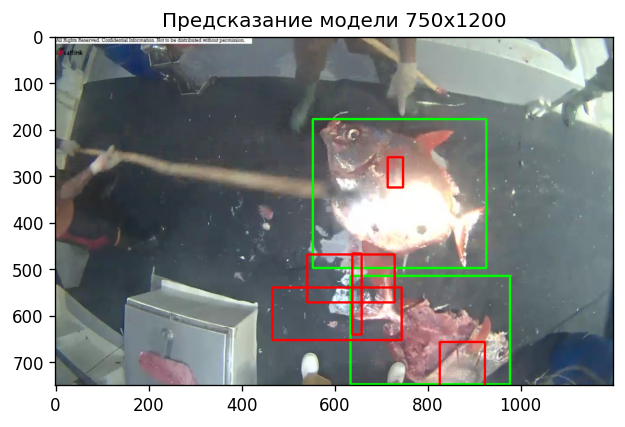

In [ ]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0][0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.2)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

1/1 [==============================] - 0s 75ms/step


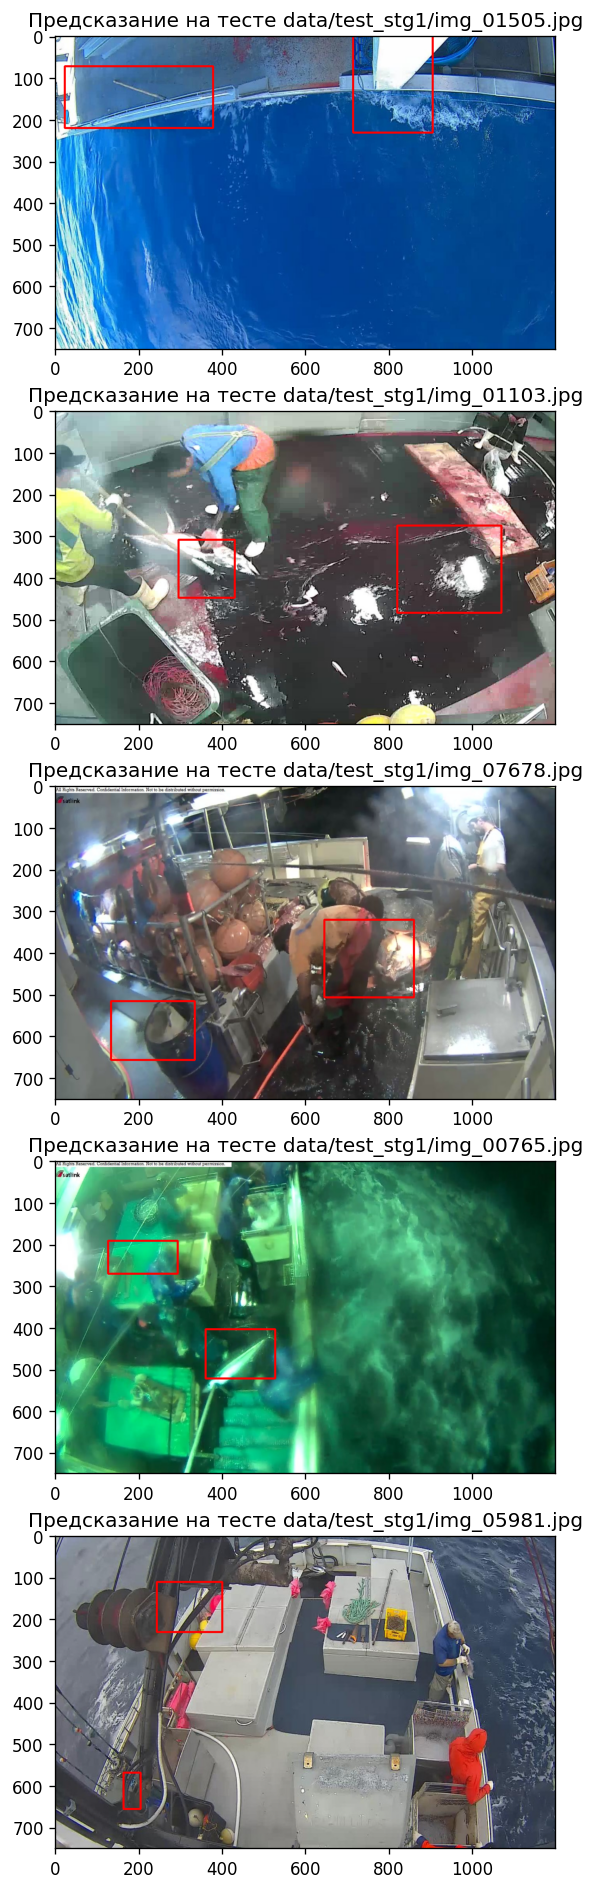

In [ ]:
test_images = glob('data/test_stg1/*.jpg')[:5]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0][0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.3)

    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

## Агрегация результатов

In [ ]:
%%time
test_images = glob('data/test_stg1/*.jpg')
filenames = []
preds = []
for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]),verbose=None)[1]
    preds.append(pred)
    filenames.append(os.path.split(filename)[1])
    print('*', end='')

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [ ]:
%%time
test_images = glob('data/test_stg2/*.jpg')
for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]),verbose=None)[1]
    preds.append(pred)
    filenames.append(r'test_stg2/' + os.path.split(filename)[1])
    print('*', end='')

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [ ]:
df_preds = pd.DataFrame(np.concatenate(preds), columns=['ALB', 'BET', 'DOL' , 'LAG', 'SHARK', 'YFT'])
df_preds

,ALB,BET,DOL,LAG,SHARK,YFT
0,0.866846,1.622363e-02,2.259490e-14,1.358263e-11,6.566125e-16,1.169305e-01
1,0.000127,2.425714e-02,2.330979e-07,2.458753e-12,1.163543e-09,9.756159e-01
2,0.856925,1.788738e-06,2.576651e-11,1.427762e-01,1.416862e-12,2.967945e-04
3,0.999956,7.291111e-07,6.014721e-15,9.193016e-08,6.304143e-15,4.354453e-05
4,1.000000,4.969850e-15,2.703678e-16,4.298822e-20,8.097540e-15,1.510038e-14
...,...,...,...,...,...,...
13148,0.999999,1.051081e-08,9.088609e-13,1.980313e-12,3.469833e-13,7.791410e-07
13149,1.000000,6.765413e-15,6.435293e-15,1.396573e-13,9.776515e-16,2.149811e-09
13150,1.000000,3.536966e-07,1.307047e-12,4.934572e-18,1.473368e-10,2.707104e-08
13151,0.465512,1.511610e-08,1.557468e-11,3.777986e-07,9.670420e-18,5.344880e-01


In [ ]:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
idx = 0
new_col = filenames
df_preds.insert(loc=idx, column='image', value=new_col)
df_preds.head()

,image,ALB,BET,DOL,LAG,SHARK,YFT
0,img_01505.jpg,0.866846,1.622363e-02,2.259490e-14,1.358263e-11,6.566125e-16,1.169305e-01
1,img_01103.jpg,0.000127,2.425714e-02,2.330979e-07,2.458753e-12,1.163543e-09,9.756159e-01
2,img_07678.jpg,0.856925,1.788738e-06,2.576651e-11,1.427762e-01,1.416862e-12,2.967945e-04
3,img_00765.jpg,0.999956,7.291111e-07,6.014721e-15,9.193016e-08,6.304143e-15,4.354453e-05
4,img_05981.jpg,1.000000,4.969850e-15,2.703678e-16,4.298822e-20,8.097540e-15,1.510038e-14


In [ ]:
idx = 5
new_col = [0.0]*len(filenames)
df_preds.insert(loc=idx, column='NoF', value=new_col)
df_preds.head()

,image,ALB,BET,DOL,LAG,NoF,SHARK,YFT
0,img_01505.jpg,0.866846,1.622363e-02,2.259490e-14,1.358263e-11,0.0,6.566125e-16,1.169305e-01
1,img_01103.jpg,0.000127,2.425714e-02,2.330979e-07,2.458753e-12,0.0,1.163543e-09,9.756159e-01
2,img_07678.jpg,0.856925,1.788738e-06,2.576651e-11,1.427762e-01,0.0,1.416862e-12,2.967945e-04
3,img_00765.jpg,0.999956,7.291111e-07,6.014721e-15,9.193016e-08,0.0,6.304143e-15,4.354453e-05
4,img_05981.jpg,1.000000,4.969850e-15,2.703678e-16,4.298822e-20,0.0,8.097540e-15,1.510038e-14


In [ ]:
idx = 6
new_col = [0.0]*len(filenames)
df_preds.insert(loc=idx, column='OTHER', value=new_col)
df_preds.head()

,image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
0,img_01505.jpg,0.866846,1.622363e-02,2.259490e-14,1.358263e-11,0.0,0.0,6.566125e-16,1.169305e-01
1,img_01103.jpg,0.000127,2.425714e-02,2.330979e-07,2.458753e-12,0.0,0.0,1.163543e-09,9.756159e-01
2,img_07678.jpg,0.856925,1.788738e-06,2.576651e-11,1.427762e-01,0.0,0.0,1.416862e-12,2.967945e-04
3,img_00765.jpg,0.999956,7.291111e-07,6.014721e-15,9.193016e-08,0.0,0.0,6.304143e-15,4.354453e-05
4,img_05981.jpg,1.000000,4.969850e-15,2.703678e-16,4.298822e-20,0.0,0.0,8.097540e-15,1.510038e-14


In [ ]:
df_preds.to_csv('submit_stg2.csv', index=False)

Private Score = 12.19160
Public Score = 11.41314